# Form factor to total density prediction model training
This notebook shows how a deep learning model can be trained to predict total density profiles from form factors. 
It contains the following steps: 
1) Download the data using the NMR lipids API
2) Preprocessing data
3) Training the ML model

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
from tensorflow import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Set TensorFlow verbosity to lowest (only print errors)

from keras import layers
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense

#import keras_tuner
#from keras_tuner.tuners import Hyperband
#from collections import Counter 
#from scipy.signal import savgol_filter

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath =  './Databank/'   # this is the local path for the cloned Databank git
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import *
from new_functions import *
systems = initialize_databank(databankPath)

/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


Extract FF and TD from the databank
The TD have different ranges and resolutions in the x plane
We want to have all of them on the same form for the machine learning model
First extrapolate by padding to ensure all have the same extension in the x direction
Then interpolate with a Gaussian Process Regression to make sure the points are in the same place
The last steps also crops away some of the tails of the widest densities

In [4]:
all_ff = []
all_td_x = []
all_td_y = []

# Load form factors and total densities
for system in systems: 
    FFsim, TDsim = get_form_factor_and_total_density(system)

    if isinstance(FFsim, list) and len(FFsim) == 1000:
        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff)

    if isinstance(TDsim, list):
        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x)
        all_td_y.append(td_y)
assert len(all_ff) == len(all_td_x) == len(all_td_y)
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 787


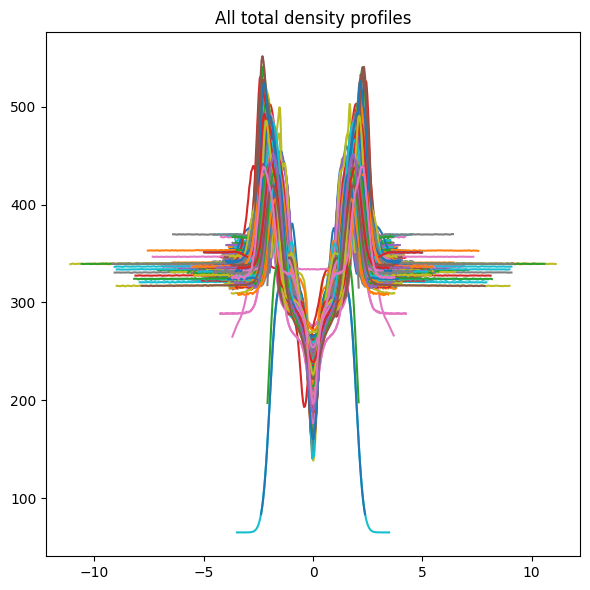

In [5]:
# Plot all total density profiles
plt.figure(figsize=(6, 6))
for x_vector, y_vector in zip(all_td_x, all_td_y):
    plt.plot(x_vector, y_vector)
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

In [6]:
# Homogenize the data format of the total densities
padded_td_x = []
padded_td_y = []

x_interval_start = -4
x_interval_end = 4
max_td_dimension = 400 # maximum allowed length of x and y in total density

for x_vector, y_vector in zip(all_td_x, all_td_y):
    x_min = min(x_vector)
    x_max = max(x_vector)
    first_pad_value = y_vector[0]
    last_pad_value = y_vector[-1]
    # The dimensions of TD vary so they must be padded to have uniform length
    padding_length = max(0, max_td_dimension - len(x_vector))
    first_padding_length = padding_length // 2
    last_padding_length = padding_length - first_padding_length
    # Check if the range of the x values is smaller than the required range: 
    if x_min > x_interval_start and x_max < x_interval_end:
        # If narrower, extrapolate in the x direction by replicating the y values at the ends
        linspace_x_start = np.linspace(x_interval_start, x_min, num=max(0, first_padding_length), endpoint=False)
        linspace_x_end = np.linspace(x_max, x_interval_end, num=max(0, last_padding_length), endpoint=False)
        extended_x = np.concatenate([linspace_x_start, x_vector, linspace_x_end])
        padded_td_x.append(extended_x[:max_td_dimension])
    else: 
        # If wider, pad at the ends without extrapolating to make dimensions equal
        repeat_x_start = np.repeat(x_min, first_padding_length)
        repeat_x_end = np.repeat(x_max, last_padding_length)
        extended_x = np.concatenate([repeat_x_start, x_vector, repeat_x_end])
        padded_td_x.append(extended_x[:max_td_dimension])

    # The y values at the beginning and end are copies and extrapolated
    # Truncate if data is longer than max_td_dimension
    # Split into x and y components
    padding_start = [first_pad_value] * first_padding_length
    padding_end = [last_pad_value] * (last_padding_length)
    padded_y = np.concatenate([padding_start, y_vector, padding_end])
    padded_td_y.append(padded_y[:max_td_dimension])

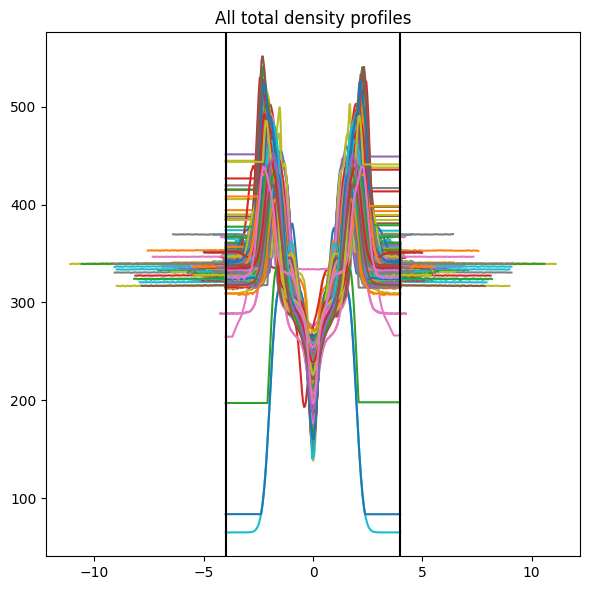

In [7]:
# Plot all total density profiles
plt.figure(figsize=(6, 6))
for x_vector, y_vector in zip(padded_td_x, padded_td_y):
    plt.plot(x_vector, y_vector)
plt.axvline(x_interval_start, color='k', linestyle='solid')
plt.axvline(x_interval_end, color='k', linestyle='solid')
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

Rescale total densities to [0,1] range based on the max and min value among all densities.
This maintains internal differences in amplitude.

In [8]:
min_ff = min(min(sublist) for sublist in all_ff)
min_td_x = min(min(sublist) for sublist in padded_td_x)
min_td_y = min(min(sublist) for sublist in padded_td_y)

max_ff = max(max(sublist) for sublist in all_ff)
max_td_x = max(max(sublist) for sublist in padded_td_x)
max_td_y = max(max(sublist) for sublist in padded_td_y)

# Min-max normalization
def rescale_array(arr, min_value, max_value):
    return (arr - min_value) / (max_value - min_value)

# Apply to each sublist in ff and td x and y
rescaled_all_ff = [rescale_array(ff, min_ff, max_ff) for ff in all_ff]
rescaled_all_td_x = [rescale_array(td_x, min_td_x, max_td_x) for td_x in padded_td_x]
rescaled_all_td_y = [rescale_array(td_y, min_td_y, max_td_y) for td_y in padded_td_y]

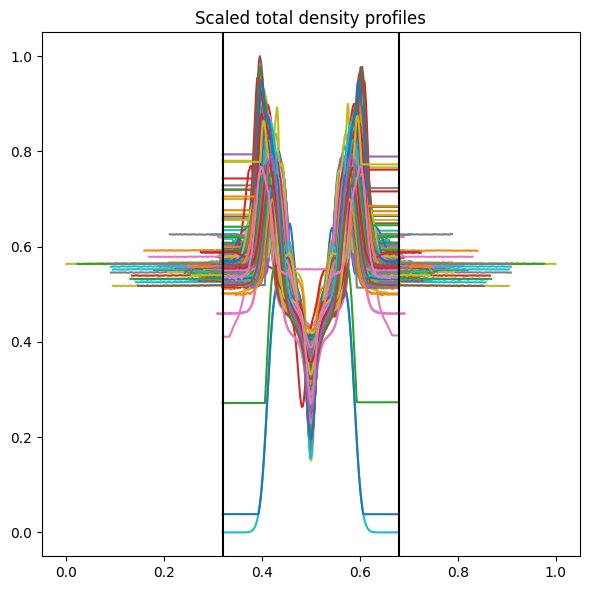

In [24]:
# Plot all total density profiles
plt.figure(figsize=(6, 6))
for x_vector, y_vector in zip(rescaled_all_td_x, rescaled_all_td_y):
    plt.plot(x_vector, y_vector)
plt.axvline(rescale_array(x_interval_start, min_td_x, max_td_x), color='k', linestyle='solid')
plt.axvline(rescale_array(x_interval_end, min_td_x, max_td_x), color='k', linestyle='solid')
plt.title('Scaled total density profiles')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import matplotlib.pyplot as plt

# Define the points for prediction
uniform_x_range = np.linspace(rescale_array(x_interval_start, min_td_x, max_td_x), rescale_array(x_interval_end, min_td_x, max_td_x), 200).reshape(-1, 1)

# y values on the uniform x grid
standardized_y = []

PLOT_GPR_FITS = False
if PLOT_GPR_FITS:
    # Plot the original data and the predictions
    plt.figure(figsize=(12, 6))

for x_vector, y_vector in zip(rescaled_all_td_x, rescaled_all_td_y):
    # Create and fit Gaussian process regressor
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
    #kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)
    
    # Note that scikit-learn expects a 2D array for the features
    gp.fit(x_vector.reshape(-1, 1), y_vector)
    
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(uniform_x_range, return_std=True)
    standardized_y.append(y_pred)
    
    # Plot the function, the prediction and the 95% confidence interval
    if PLOT_GPR_FITS:
        plt.plot(uniform_x_range, y_pred, label='GPR Prediction')
        plt.fill_between(uniform_x_range.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5)
        plt.scatter(x_vector, y_vector, label='Training Points', c='red')
        plt.show()

# Set labels and legend
if PLOT_GPR_FITS:
    plt.xlabel('X values')
    plt.ylabel('Predicted Y values')
    plt.legend()
    plt.show()

/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bo

### Gather form factors and total densities in data frames

With the databank initiated, the form factor (ff) and total density (td) data of each simulation can be extracted from the "systems" variable.
Each form factor has a shape of (1000), but the total densities have dimensions that vary. 
Therefore, the total density data are padded with nan in the x and y dimensions to ensure a uniform shape of (200,2). 
After all data is collected, the total densities are split into separate data frames td_x and td_y for each dimension.

In [11]:
# Convert the data to a pandas DataFrame
sim_FF_df = pd.DataFrame(rescaled_all_ff)
sim_TD_y_df = pd.DataFrame(standardized_y)

Get to know the data at a glance by calling the df name in a code block.

In [12]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.017178,0.017147,0.017056,0.016903,0.016690,0.016416,0.016081,0.015686,0.015230,0.014714,...,0.003548,0.003657,0.003764,0.003869,0.003973,0.004076,0.004177,0.004276,0.004373,0.004469
1,0.071871,0.071839,0.071744,0.071585,0.071362,0.071076,0.070727,0.070314,0.069839,0.069300,...,0.000893,0.000944,0.000994,0.001043,0.001092,0.001140,0.001188,0.001236,0.001282,0.001328
2,0.039322,0.039339,0.039389,0.039473,0.039591,0.039742,0.039927,0.040145,0.040396,0.040681,...,0.000599,0.000485,0.000382,0.000300,0.000258,0.000275,0.000341,0.000433,0.000538,0.000648
3,0.035077,0.035043,0.034942,0.034773,0.034537,0.034234,0.033863,0.033426,0.032922,0.032351,...,0.008975,0.009019,0.009061,0.009100,0.009136,0.009170,0.009201,0.009230,0.009256,0.009279
4,0.016793,0.016764,0.016679,0.016535,0.016335,0.016078,0.015763,0.015392,0.014964,0.014480,...,0.001514,0.001587,0.001660,0.001732,0.001804,0.001875,0.001945,0.002015,0.002084,0.002153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.041878,0.041852,0.041773,0.041642,0.041459,0.041224,0.040936,0.040596,0.040205,0.039761,...,0.000576,0.000614,0.000654,0.000695,0.000737,0.000780,0.000824,0.000870,0.000916,0.000964
783,0.020638,0.020608,0.020519,0.020371,0.020163,0.019897,0.019571,0.019187,0.018744,0.018242,...,0.001113,0.001168,0.001226,0.001284,0.001343,0.001403,0.001464,0.001525,0.001586,0.001648
784,0.051984,0.051954,0.051865,0.051715,0.051507,0.051238,0.050911,0.050524,0.050078,0.049573,...,0.005728,0.005785,0.005842,0.005900,0.005959,0.006017,0.006076,0.006136,0.006195,0.006255
785,0.046032,0.045998,0.045896,0.045727,0.045491,0.045187,0.044816,0.044379,0.043874,0.043303,...,0.000158,0.000142,0.000142,0.000160,0.000191,0.000229,0.000272,0.000319,0.000367,0.000416


In [13]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.539433,0.539327,0.539103,0.539349,0.539118,0.539173,0.539492,0.538363,0.536193,0.535608,...,0.533968,0.535919,0.537792,0.538351,0.538183,0.538198,0.538251,0.538186,0.538251,0.538334
1,0.549324,0.549774,0.551552,0.549744,0.547623,0.548279,0.549149,0.548920,0.549263,0.550507,...,0.547821,0.548393,0.548561,0.548771,0.550488,0.552021,0.550529,0.548252,0.548912,0.549267
2,0.557691,0.557685,0.557706,0.557694,0.557688,0.557707,0.557698,0.557683,0.557699,0.557711,...,0.558113,0.558104,0.558094,0.558106,0.558110,0.558096,0.558104,0.558106,0.558100,0.557960
3,0.546070,0.546074,0.546149,0.546096,0.546094,0.546156,0.546107,0.546069,0.546143,0.546159,...,0.544382,0.544456,0.544476,0.544406,0.544417,0.544472,0.544421,0.544427,0.544450,0.544615
4,0.554435,0.554432,0.554416,0.554429,0.554426,0.554414,0.554429,0.554431,0.554415,0.554418,...,0.553842,0.553884,0.553874,0.553844,0.553864,0.553877,0.553851,0.553867,0.553861,0.553869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.522984,0.522985,0.522989,0.522994,0.522979,0.522989,0.522999,0.522981,0.522978,0.522999,...,0.522697,0.522698,0.522691,0.522692,0.522698,0.522693,0.522692,0.522697,0.522692,0.522659
783,0.554451,0.554444,0.554417,0.554435,0.554440,0.554412,0.554432,0.554453,0.554415,0.554400,...,0.556038,0.556047,0.555965,0.555988,0.556049,0.555988,0.555986,0.556038,0.555970,0.555784
784,0.524311,0.524315,0.524305,0.524338,0.524278,0.524315,0.524351,0.524275,0.524282,0.524382,...,0.523593,0.523685,0.523703,0.523653,0.523669,0.523690,0.523660,0.523677,0.523669,0.523668
785,0.518651,0.518871,0.518733,0.518501,0.518645,0.519178,0.519615,0.519562,0.519150,0.518848,...,0.519548,0.519299,0.518742,0.518614,0.519026,0.519342,0.519114,0.518676,0.518563,0.518724


### Plot form factors and total densities

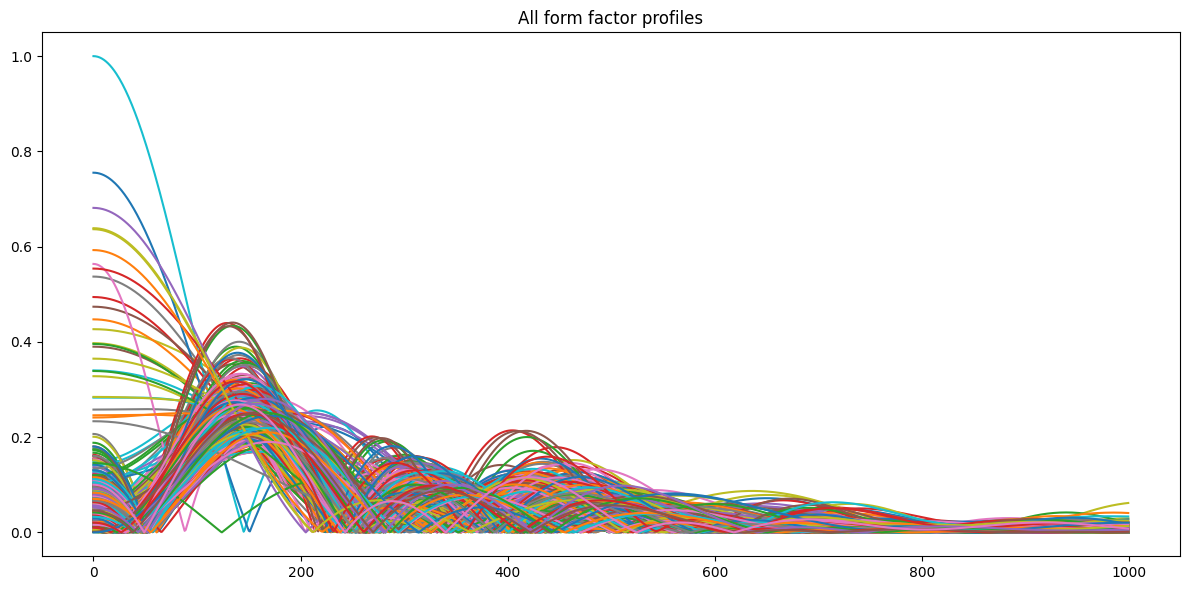

In [14]:
# Plot all form factors
plt.figure(figsize=(12, 6))
for index, row in sim_FF_df.iterrows():
    plt.plot(row.to_list())
plt.title('All form factor profiles')
plt.tight_layout()
plt.show()

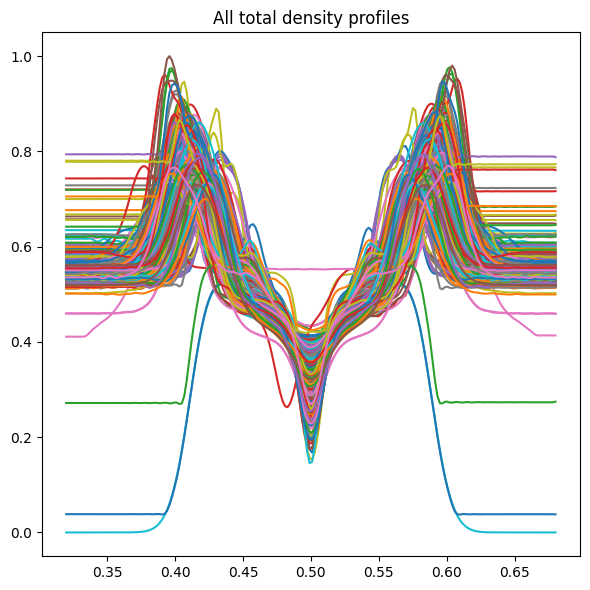

In [15]:
# Plot all total density profiles in the df
plt.figure(figsize=(6, 6))
for index, row in sim_TD_y_df.iterrows():
    plt.plot(uniform_x_range, row.to_list())
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

Rescaling is now already done and we have homogenized y values

Split into train and test

In [16]:
def split_train_and_test(sim_FF_df, sim_TD_y_df):
    N_total = sim_FF_df.shape[0]
    N_train = int(round(0.8*N_total,0))
    shuffle_indices = rng.permutation(N_total)
    train_indices = shuffle_indices[0:N_train]
    test_indices = shuffle_indices[N_train:]

    # Select, transpose or not, and convert to numpy float
    train_input = sim_FF_df.loc[train_indices,:].astype(np.float32)
    train_output = sim_TD_y_df.loc[train_indices,:].astype(np.float32)
    test_input = sim_FF_df.loc[test_indices,:].astype(np.float32)
    test_output = sim_TD_y_df.loc[test_indices,:].astype(np.float32)
    
    print("train_input.shape:", train_input.shape)
    print("train_output.shape:", train_output.shape)
    print("test_input.shape:", test_input.shape)
    print("test_output.shape:", test_output.shape)

    return train_input, train_output, test_input, test_output 

train_input, train_output, test_input, test_output = split_train_and_test(sim_FF_df, sim_TD_y_df)
N_train = train_input.shape[0]
N_test = test_input.shape[0]

train_input.shape: (630, 1000)
train_output.shape: (630, 200)
test_input.shape: (157, 1000)
test_output.shape: (157, 200)


In [17]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
150,0.093309,0.093272,0.093161,0.092976,0.092718,0.092386,0.091981,0.091503,0.090951,0.090327,...,0.000705,0.000761,0.000817,0.000874,0.000930,0.000987,0.001044,0.001101,0.001157,0.001214
536,0.064981,0.064943,0.064830,0.064642,0.064378,0.064039,0.063626,0.063137,0.062574,0.061937,...,0.004635,0.004801,0.004966,0.005131,0.005296,0.005459,0.005622,0.005784,0.005945,0.006105
74,0.032678,0.032647,0.032551,0.032391,0.032168,0.031881,0.031531,0.031117,0.030640,0.030100,...,0.002398,0.002420,0.002443,0.002465,0.002487,0.002509,0.002531,0.002553,0.002575,0.002597
754,0.017237,0.017206,0.017114,0.016961,0.016747,0.016471,0.016135,0.015738,0.015280,0.014762,...,0.001607,0.001614,0.001621,0.001628,0.001634,0.001641,0.001647,0.001654,0.001660,0.001667
151,0.013712,0.013681,0.013586,0.013429,0.013209,0.012927,0.012581,0.012174,0.011704,0.011172,...,0.002769,0.002784,0.002798,0.002812,0.002824,0.002836,0.002847,0.002856,0.002865,0.002874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.018978,0.018956,0.018890,0.018779,0.018625,0.018426,0.018184,0.017898,0.017568,0.017194,...,0.001563,0.001543,0.001523,0.001503,0.001482,0.001460,0.001439,0.001417,0.001394,0.001371
169,0.003264,0.003240,0.003169,0.003049,0.002882,0.002667,0.002405,0.002095,0.001738,0.001333,...,0.002366,0.002273,0.002180,0.002086,0.001993,0.001900,0.001808,0.001716,0.001625,0.001536
228,0.397424,0.397413,0.397381,0.397328,0.397252,0.397154,0.397035,0.396895,0.396733,0.396550,...,0.011119,0.011090,0.011054,0.011013,0.010966,0.010913,0.010854,0.010789,0.010718,0.010641
436,0.007224,0.007195,0.007108,0.006963,0.006760,0.006499,0.006180,0.005804,0.005370,0.004879,...,0.004284,0.004385,0.004485,0.004584,0.004681,0.004777,0.004871,0.004964,0.005056,0.005146


In [18]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
150,0.551935,0.551935,0.551941,0.551935,0.551935,0.552134,0.552341,0.552240,0.552040,0.552212,...,0.552534,0.552522,0.552270,0.551976,0.551760,0.551613,0.551589,0.551621,0.551589,0.551546
536,0.562133,0.561267,0.562100,0.561031,0.561277,0.561440,0.561108,0.561123,0.561405,0.561284,...,0.560994,0.561015,0.561108,0.561309,0.561503,0.561581,0.561684,0.561766,0.560948,0.561697
74,0.548331,0.548630,0.549085,0.549191,0.549063,0.548947,0.548927,0.548971,0.549034,0.549109,...,0.548921,0.548992,0.548973,0.548957,0.549063,0.549125,0.548958,0.548767,0.548789,0.548651
754,0.556993,0.557133,0.557174,0.557086,0.556987,0.556974,0.557074,0.557199,0.557193,0.557041,...,0.557138,0.557282,0.557038,0.556608,0.556547,0.557046,0.557440,0.557213,0.556926,0.557356
151,0.566827,0.566809,0.566763,0.566752,0.566902,0.567229,0.567526,0.567491,0.567074,0.566626,...,0.566573,0.566568,0.566651,0.566621,0.566485,0.566447,0.566587,0.566728,0.566709,0.566570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.545237,0.545238,0.545245,0.545243,0.545237,0.545246,0.545245,0.545236,0.545241,0.545250,...,0.544935,0.544949,0.544948,0.544936,0.544942,0.544948,0.544939,0.544943,0.544943,0.544958
169,0.549031,0.549029,0.549030,0.549023,0.549036,0.549029,0.549019,0.549034,0.549039,0.549020,...,0.548733,0.548757,0.548748,0.548730,0.548745,0.548752,0.548734,0.548746,0.548742,0.548770
228,0.667774,0.667787,0.667746,0.667756,0.667792,0.667744,0.667739,0.667794,0.667779,0.667723,...,0.666535,0.666597,0.666597,0.666540,0.666564,0.666605,0.666548,0.666576,0.666562,0.667266
436,0.550718,0.550730,0.550589,0.550436,0.550512,0.550741,0.550808,0.550711,0.550861,0.551350,...,0.550895,0.550875,0.551223,0.551503,0.551272,0.550757,0.550615,0.551079,0.551580,0.551485


### Train a neural net

Here are different metrics and plotting functions for analyzing the model's performance. The loss metric is a mean squared error for data points (x,y) because it helps compare the score to the plots. The actual model will not be trained using this kind of loss because it is less efficient and hurts accuracy, so the mean absolute error is used instead.

In [ ]:
general_start_time = time.time()

# Callbacks are separate functions for chancing behavior of training. 
# In this case we only use EarlyStopping, which stops training, when 
# the validation loss doesn't become smaller after 100 epochs.
# Then the best weights from previous epochs are saved into a model
callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

# This defines an Amsgrad variant of the Adam optimizer. Usually some variant 
# of Adam is first used to give an idea for performance, before other optimizers are used  
Adam = tf.keras.optimizers.Adam(amsgrad=True)

# This defines the given input to be a 1000 long vector
inputs = keras.Input(shape=(1000,))

# This defines a regular neural network layer of 1000 neurons using the activation function called reLu.
# ReLu is also usually used to give an idea for perfomrance, before other activation functions are used
x = layers.Dense(1000, activation='relu')(inputs)

# This defines an output layer, which is a regular neural network layer of 400 neurons using the 
# linear activation function, which means all neurons are activated with their weighted outputs.
outputs = layers.Dense(200, activation='linear')(x)

# This defines a model architecture
model = keras.Model(inputs=inputs, outputs=outputs)

# This compiles a model using a Adam optimizer and the intended training loss, which is mean absolute error
# Usually mean squared error is used for regression predictions, but since the output isn't suitable for it
# due to keras loss functions not knowing the division of x-axis and y-axis values, mean absolute error is used
model.compile(optimizer=Adam, loss='mean_absolute_error')

# This used the given training data to traing the model with 
# max 1500 epochs, validation split of 20 % and a training batch size of 128.
# Usually epoch amounts are around 20 to 100, which is why we are giving the model a lot of tries to adjust
# The given batch size divides the available training data of 490 into 128,128,128 and 106 separate batches 
# that are used to train the network. Larger batch sizes make the network converge faster, while smaller batch sizes 
# make the network updates more granural, increasing the used time 
history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

# Time use
general_end_time = time.time()
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

Used time: 23.926236867904663 seconds


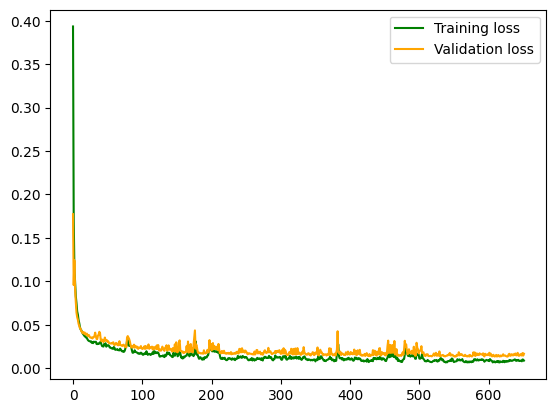

In [20]:
## Here we used the defined metrics to evaluate predicted TotalDensities against test TotalDensities
#results = metrics(test_output, model.predict(test_input))

# These plot the training history of the model
plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

#print('Loss average is: ' + str(results[0]))
#print('Loss mode is: ' + str(results[1]))
#print('Loss median is: ' + str(results[2]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


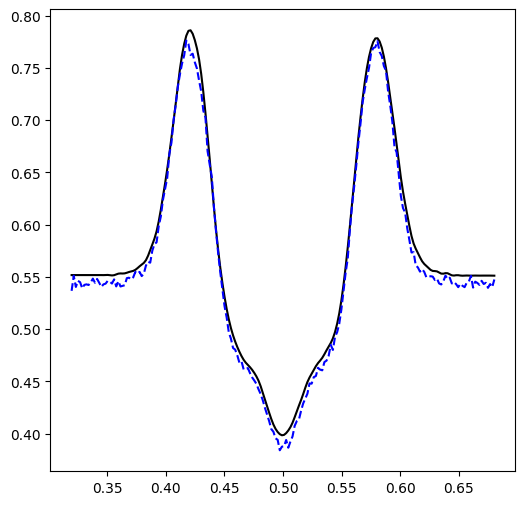

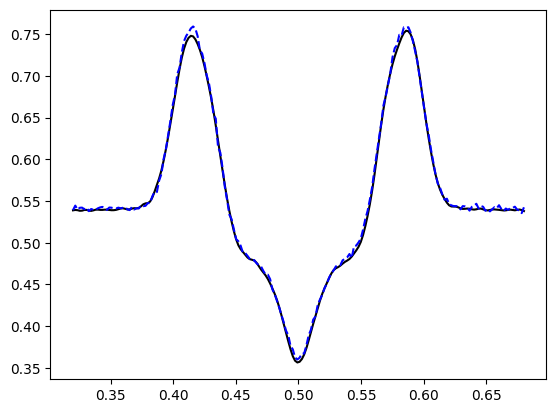

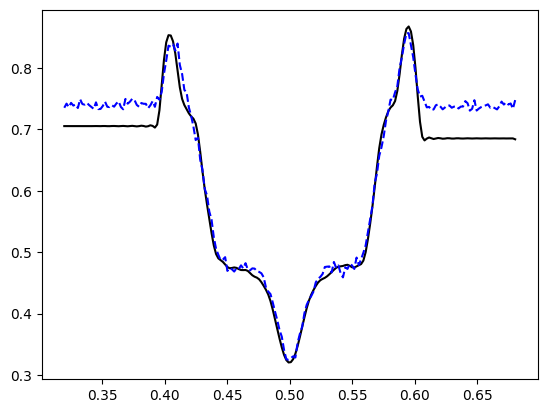

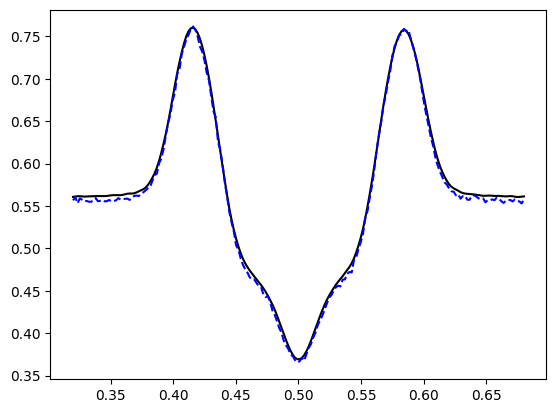

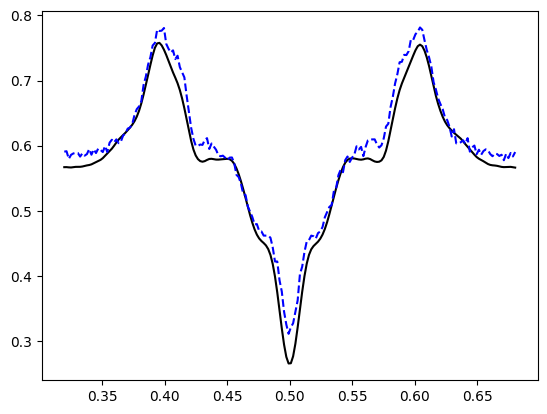

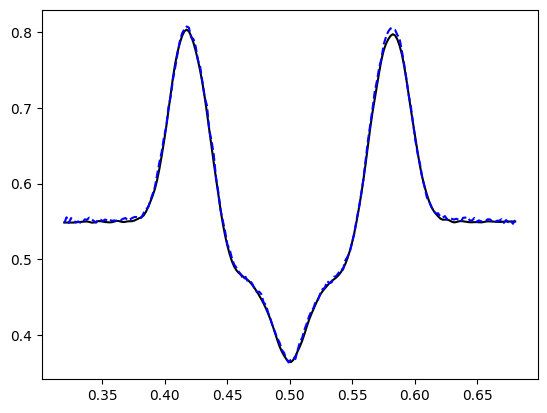

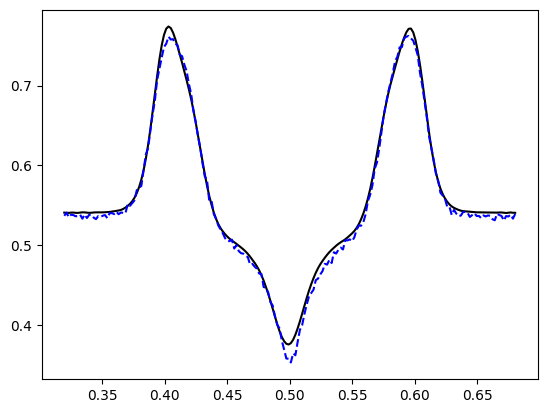

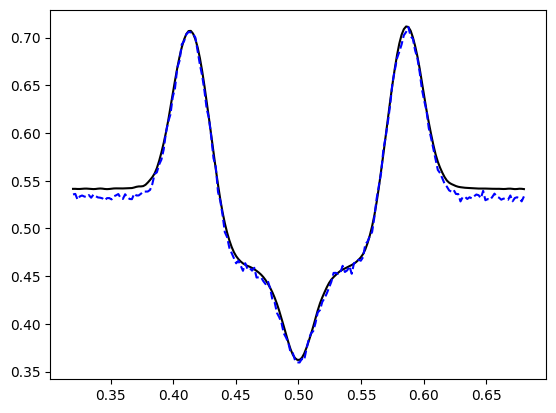

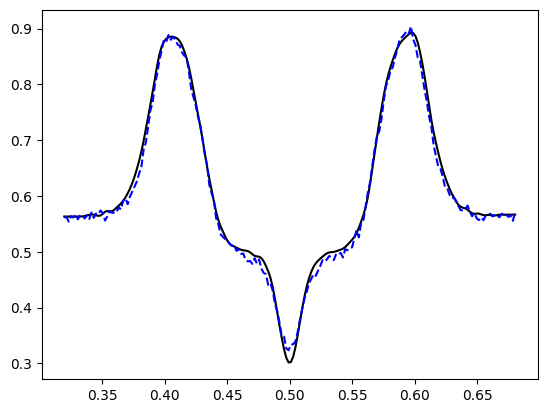

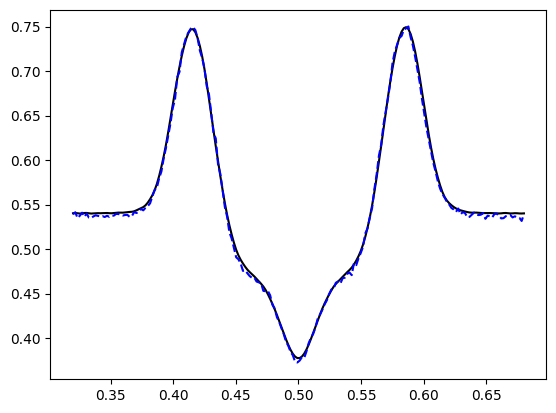

<Figure size 640x480 with 0 Axes>

In [22]:
# Compare predictions to truth
predictions = model.predict(test_input)
#print(test_output.index) # Index has not been reset so the original ones are maintained
#print(test_output.values)
random_test_indices = rng.integers(low=0, high=N_test, size=10)
plt.figure(figsize=(6, 6))
for idx in random_test_indices:
    plt.plot(uniform_x_range, test_output.values[idx], color="k", linestyle="-")
    plt.plot(uniform_x_range, predictions[idx], color="b", linestyle="--")
    plt.show()
plt.tight_layout()
plt.show()